# Lab 3 - Decision Trees

This assignment uses a dataset obtained from the JSE Data Archive that aims at identifying whether there is a statistically significant dependence between gender and biological/activity traits in humans. 

FEATURE DESCRIPTIONS: 

<ul>
<li>Color (Blue, Brown, Green, Hazel, Other)
<li>Age (in years)
<li>YearinSchool (First, Second, Third, Fourth, Other)
<li>Height (in inches)
<li>Miles (distance from home town of student to Ames, IA) 
<li>Brothers (number of brothers)
<li>Sisters (number of sisters)
<li>CompTime (number of hours spent on computer per week)
<li>Exercise (whether the student exercises Yes or No)
<li>ExerTime (number of hours spent exercising per week)
<li>MusicCDs (number of music CDs student owns)
<li>PlayGames (number of hours spent playing games per week)
<li>WatchTV (number of hours spent watching TV per week
</ul>

https://ww2.amstat.org/publications/jse/jse_data_archive.htm

In [1]:
from collections import Counter, defaultdict
from itertools import combinations 
import pandas as pd
import numpy as np
import operator

In [2]:
df = pd.read_csv('Eye_Color.csv')

In [3]:
# remove NA's and reset the index
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df = df.reset_index(drop=True)

In [4]:
df.head()

,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


# Calculating Gini Index 

$Gini(D) = 1 - \sum_{i=1}^m p_i^2$

In [5]:
def gini(l):
    count = np.sum(l)
    gini = 1
    for p in l:
        gini -= np.square(p/count)
    return gini 

$Gini_A(D) = \frac{|D_1|}{|D|}Gini(D_1) + \frac{|D_2|}{|D|}Gini(D_2)$

In [6]:
def gini_split(l_1, l_2):
    total = np.sum(l_1) + np.sum(l_2)
    return (np.sum(l_1)/total)*gini(l_1) + (np.sum(l_2)/total)*gini(l_2)

$\Delta Gini(A) = Gini(D) - Gini_A(D)$

In [7]:
def gini_delta():
    print('TODO')



**Question 1: How many rows are there in the dataset for males? For females? **



In [8]:
df.groupby('gender').size()

gender
female    1078
male       910
dtype: int64

**Question 2: What is the Gini Index of this dataset, using males and females as the target classes?**

In [9]:
print(gini(df.groupby('gender').size().tolist()))

0.4964292799047808


## Best Split of a Numeric Feature

**Question 3: What is the best split point of the 'height' feature. **

In [10]:
min_height = int(df['height'].min())
max_height = int(df['height'].max())

partitioning = []
for height in range(min_height, max_height):
    tall = df.query('height>'+str(height))
    small = df.query('height<='+str(height))
    
    d_1 = tall.groupby('gender').size().tolist()
    d_2 = small.groupby('gender').size().tolist()
    
    partitioning.append({
        'height': height,
        'partitions': [
            d_1,
            d_2
        ],
        'gini': gini_split(d_1, d_2)
    })

best_partitioning = partitioning[0]
for p in partitioning:
    if p['gini'] < best_partitioning['gini']:
        best_partitioning = p
        
print(best_partitioning) 

{'height': 68, 'partitions': [[173, 768], [905, 142]], 'gini': 0.26552881207029194}


**Question 4: What is the Gini Index of this best split?**

In [11]:
best_partitioning['gini']

0.26552881207029194

**Question 5: How much does this partitioning reduce the Gini Index over that of the overall dataset?**

In [12]:
delta = gini(df.groupby('gender').size().tolist()) - best_partitioning['gini']
print(delta)

0.23090046783448887


**Question 6: How many 'female' rows are below your best split point? 'male' rows?**

In [13]:
print('Below 68.0 :: Female:', best_partitioning['partitions'][1][0], '/ Male:', best_partitioning['partitions'][1][1])

Below 68.0 :: Female: 905 / Male: 142


**Question 7: How many 'female' rows are above your best split point? 'male' rows?**

In [14]:
print('Above 68.0 :: Female:', best_partitioning['partitions'][0][0], '/ Male:', best_partitioning['partitions'][0][1])

Above 68.0 :: Female: 173 / Male: 768


Recall that, to calculate the best split of this numeric field, you'll need to order your data by 'height', then consider the midpoint between each pair of consecutive heights as a potential split point, then calculate the Gini Index for that partitioning. You'll want to keep track of the best split point and its Gini Index (remember that you are trying to minimize the Gini Index). 

There are a lot of ways to do this. Some are very fast, others very slow. One tip to make this run quickly is, as you consecutively step through the data and calculate the Gini Index of each possible split point, keep a running total of the number of rows for each candidate that are located above and below the split point. 

Some Python tips: 

* Counter(), from the collections module, is a special dictionary for counting values of a key
* zip() lets you concatenate lists into a list of tuples (for example, if we have a list of the candidates and a list of transaction amounts, zip(candidate_list, transaction_amount) would give us a list of (candidate, transaction amount) pairs

## Best Split of a Categorial Variable

**Question 8: How many possible splits are there of the eyecolor feature?**

In [15]:
# There are two ways of how to interpret this question:
# [1] How many possible binary splits are there?
# [2] How many possible (arbitrary) splits are there?
#
# In the following I will describe the branching possibilities for 
# both interpretations.
# Going on with question 9 I only compare the different binary splits.
# The reason for that is that (according to the lecture) the Gini 
# impurity measure is only suited for binary splits.

# [1] How many possible BINARY splits are there of the eyecolor feature?

from itertools import chain, combinations

def powerset(iterable):
    'powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)'
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

# values = ['Blue', 'Brown', 'Green', 'Hazel', 'Other']
#         [   1   ,    2   ,   3    ,   4   ,     5   ]
# for result in powerset([1, 2, 3, 4, 5]):
#     print(result)

binary_splits = list(powerset(['blue', 'brown', 'green', 'hazel', 'other']))

# remove 2 from the length of the array to account for the trivial sets
# () and (1,2,3,4,5), which ar equivalent to not splitting at all. 
print('Q8 (binary) ::', len(binary_splits)-2, 'different non-trival binary splits are possible')

# => For binary splits we can just calculate the power set. 
#    It lists all possible combinations of combining n distinct  
#    values into [0,n] sized tuples.
#    The power set also contains trivial sets (all or non of the values), which
#    are not interesting for our use case.




# [2] How many possible ARBITRARY splits are there of the eyecolor feature?

# This question is more difficult to answer. It comes down to the following: 
# We have 5 values, now how can they be partitioned given that ...
#   - The order of elements in each partition (aka branch of the tree) does not matter.
#   - The order of partitions does not matter.
#   - There can be up to 5 branches, even though we want to predict only 2 targets. 


# I could not find a way to systematically generate all partitions, but would be very 
# interested in the solutions to this problem.
# I listed all possible splits below, sorted by the number of branches the result in.

# Note: Could you please share the code of how to generate the list of combinations with itertools?

# values = ['Blue', 'Brown', 'Green', 'Hazel', 'Other']
#         [   1   ,    2   ,   3    ,   4   ,     5   ]
aribtrary_splits = [
# 5 branches (1 option) => (5 choose 5 = 1)
    #(1,1,1,1,1)
    [(1), (2), (3), (4), (5)],
    
# 4 branches (10 options) 
    # (2,1,1,1) => (5 choose 3 = 10)
    [(1,2), (3), (4), (5)],
    [(1,3), (2), (4), (5)],
    [(1,4), (2), (3), (5)],
    [(1,5), (2), (3), (4)],
    [(1), (2,3), (4), (5)],
    [(1), (2,4), (3), (5)],
    [(1), (2,5), (3), (4)],
    [(1), (2), (3,4), (5)],
    [(1), (2), (3,5), (4)],
    [(1), (2), (3), (4,5)],
    
# 3 branches (10 options + 15 options) 
    # (3, 1, 1)  => (5 choose 2 = 10)
    [(1,2,3), (4), (5)],
    [(1,2,4), (3), (5)],
    [(1,2,5), (3), (4)],
    [(1,3,4), (2), (5)],
    [(1,3,5), (2), (4)],
    [(1,4,5), (2), (3)],
    [(2,3,4), (1), (5)],
    [(2,3,5), (1), (4)],
    [(2,4,5), (1), (3)],
    [(3,4,5), (1), (2)],
    
    #(2,2,1)  => (?? = 15 options)
    # Could not find the combinatorical solution to how
    # many possible splits are there...
    # Maybe ((5 choose 1)(4 choose 2) / 2)
    [(1), (2,3), (4,5)],
    [(1), (2,4), (3,5)],
    [(1), (2,5), (3,4)],
    [(2), (1,3), (4,5)],
    [(2), (1,4), (3,5)],
    [(2), (1,5), (3,4)],
    [(3), (1,2), (4,5)],
    [(3), (1,4), (2,5)],
    [(3), (1,5), (2,4)],
    [(4), (1,2), (3,5)],
    [(4), (1,3), (2,5)],
    [(4), (1,5), (2,3)],
    [(5), (1,2), (3,4)],
    [(5), (1,3), (2,4)],
    [(5), (1,4), (2,3)],
    
# 2 branches (5 options + 10 options)
    # (4,1)  => (5 choose 1 = 5)
    [(1), (2,3,4,5)],
    [(2), (1,3,4,5)] ,
    [(3), (1,2,4,5)],
    [(4), (1,2,3,5)],
    [(5), (1,2,3,4)],
    
    # (2,3)  => (5 choose 2 = 10)
    [(1,2),(3,4,5)],
    [(1,3),(2,4,5)],
    [(1,4),(2,3,5)],
    [(1,5),(2,3,4)],
    [(2,3),(1,4,5)],
    [(2,4),(1,3,5)],
    [(2,5),(1,3,4)],
    [(3,4),(1,2,5)],
    [(3,5),(1,2,4)],
    [(4,5),(1,2,3)],
    
# 1 branche (1 option) 
    # ignore because this is the same as not using the feature to split at all
    # (5)  => (5 choose 0 = 1)
    #[(1,2,3,4,5)]

]

print('Q8 (arbitrary) ::', len(aribtrary_splits), 'different non-trival arbitray splits are possible')


Q8 (binary) :: 30 different non-trival binary splits are possible
Q8 (arbitrary) :: 51 different non-trival arbitray splits are possible


**Question 9: Which split of eyecolor best splits the female and male rows, as measured by the Gini Index?**

In [16]:
partitioning = []
for split in binary_splits: 
    left = df.query('eyecolor in '+str(split))
    right =  df.query('eyecolor not in '+str(split))
    
    d_1 = left.groupby('gender').size().tolist()
    d_2 = right.groupby('gender').size().tolist()
    
    partitioning.append({
        'eyecolors': split,
        'partitions': [
            d_1,
            d_2
        ],
        'gini': gini_split(d_1, d_2)
    })
    
    #print(split, gini_split(d_1, d_2), len(d_1), len(d_2))

best_partitioning = partitioning[0]
for p in partitioning:
    if p['gini'] < best_partitioning['gini']:
        best_partitioning = p
        
print(best_partitioning) 



{'eyecolors': ('green',), 'partitions': [[190, 107], [888, 803]], 'gini': 0.4930915729509777}


**Question 10: What is the Gini Index of this best split?**

In [17]:
best_partitioning['gini']

0.4930915729509777

**Question 11: How much does this partitioning reduce the Gini Index over that of the overall data set?**

In [18]:
delta = gini(df.groupby('gender').size().tolist()) - best_partitioning['gini']
print(delta)

# Given the marginal improvement one can assume that there is no correlation 
# between eyecolor and gender.

0.003337706953803088


**Question 12: How many 'female' rows and 'male' rows are in your first partition? How many 'female' rows and 'male' rows are in your second partition?**

In [19]:
print('Green Eyes :: Female:', best_partitioning['partitions'][0][0], '/ Male:', best_partitioning['partitions'][0][1])

Green Eyes :: Female: 190 / Male: 107


Python tip: the combinations function of the itertools module allows you to enumerate combinations of a list. You might want to Google 'power set'.

In [20]:
print('[Blue, Brown, Hazel, Other] Eyes :: Female:', best_partitioning['partitions'][1][0], '/ Male:', best_partitioning['partitions'][1][1])

[Blue, Brown, Hazel, Other] Eyes :: Female: 888 / Male: 803


## Training a decision tree

**Question 13: Using all of the features in the original dataframe read in at the top of this notebook, train a decision tree classifier that has a depth of three (including the root node and leaf nodes). What is the accuracy of this classifier on the training data?**

Scikit-learn classifiers require class labels and features to be in numeric arrays. As such, you will need to turn your categorical features into numeric arrays using DictVectorizer. This is a helpful notebook for understanding how to do this: http://nbviewer.ipython.org/gist/sarguido/7423289. You can turn a pandas dataframe of features into a dictionary of the form needed by DictVectorizer by using df.to_dict('records'). Make sure you remove the class label first (in this case, gender). If you use the class label as a feature, your classifier will have a training accuracy of 100%! The example notebook link also shows how to turn your class labels into a numeric array using sklearn.preprocessing.LabelEncoder().

In [21]:
import sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_extraction import DictVectorizer #to turn categorial variables into numeric arrays
from sklearn import preprocessing #to transform the feature labels

features_df = df.drop(columns = ['gender'])
features = features_df.to_dict('records')
target = df['gender']

vec = DictVectorizer()
features = vec.fit_transform(features).toarray()

le = preprocessing.LabelEncoder()
le.fit(["male", "female"])
target = le.transform(target)


**Question 14: Using the following code snippet, export your decision tree to graphviz and visualize it. In your write-up, write down the interpretation of the rule at each node which is used to perform the splitting.**

In order to install graphviz, you may need to download the tool from [this website](https://graphviz.gitlab.io), and then pip3/conda install the python libraries you do not have.

Mac users can use ```brew install graphviz``` instead of following the link, and linux users can do the same using their favourite package manager (for example, Ubuntu users can use ```sudo apt-get install graphviz```, followed by the necessary pip3/conda installations.

0.8646881287726358


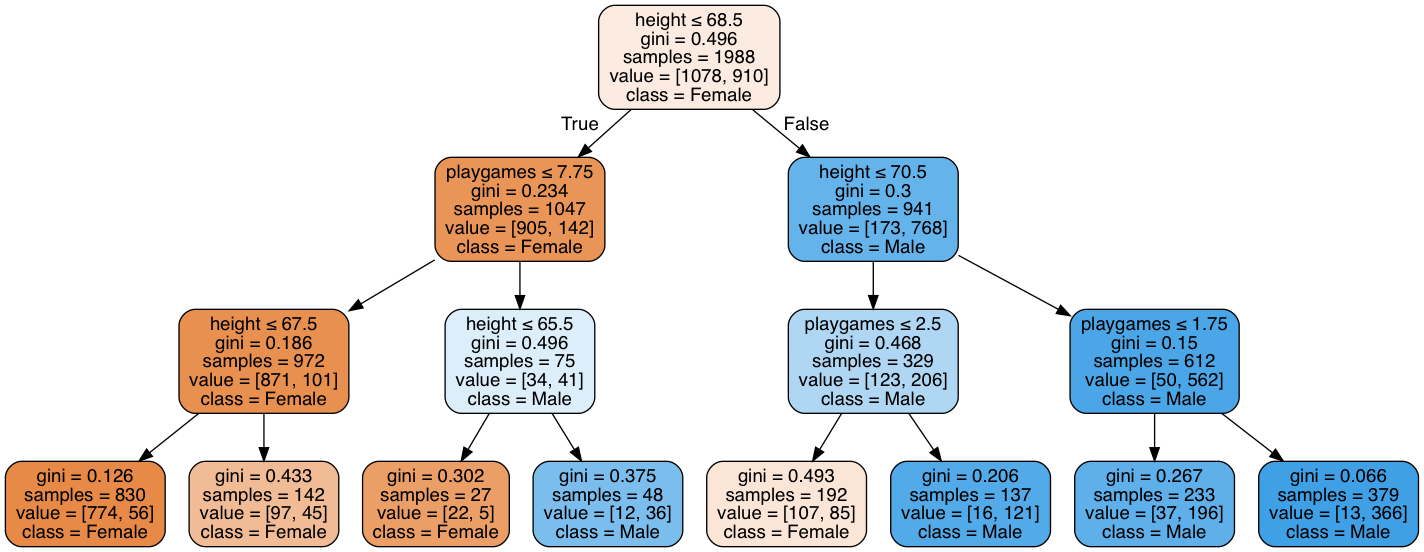

In [22]:
from IPython.display import Image  
import pydotplus 
import pydot
from sklearn.externals.six import StringIO

clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(features, target)

print(clf.score(features, target))

dotfile = StringIO() 
export_graphviz(clf, out_file=dotfile,
                    feature_names=vec.get_feature_names(),  
                    class_names=['Female', 'Male'],  
                    filled=True, rounded=True,  
                    special_characters=True)
                    
graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
Image(graph.create_png())

**Question 15 (Extra Credit): For each of your leaf nodes, specify the percentage of 'female' rows in that node (out of the total number of rows at that node).**

See this notebook for the basics of training a decision tree in scikit-learn and exporting the outputs to view in graphviz: http://nbviewer.ipython.org/gist/tebarkley/b68c04d9b31e64ce6023

In [29]:
node_count = clf.tree_.node_count
left_children = clf.tree_.children_left
right_children = clf.tree_.children_right


node_depth = np.zeros(shape=node_count, dtype=np.int64)
is_leaves = np.zeros(shape=node_count, dtype=bool)

stack = [(0, -1)]
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    if (left_children[node_id] != right_children[node_id]):
        stack.append((left_children[node_id], parent_depth + 1))
        stack.append((right_children[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
for i in range(node_count):
    if is_leaves[i]:
        fraction = clf.tree_.value[i][0][0] / (clf.tree_.value[i][0][0] + clf.tree_.value[i][0][1])
        print('Node', i, '::', fraction, '% female and', 1-fraction,'% male')

Node 3 :: 0.9325301204819277 % female and 0.06746987951807226 % male
Node 4 :: 0.6830985915492958 % female and 0.31690140845070425 % male
Node 6 :: 0.8148148148148148 % female and 0.18518518518518523 % male
Node 7 :: 0.25 % female and 0.75 % male
Node 10 :: 0.5572916666666666 % female and 0.44270833333333337 % male
Node 11 :: 0.11678832116788321 % female and 0.8832116788321168 % male
Node 13 :: 0.15879828326180256 % female and 0.8412017167381974 % male
Node 14 :: 0.03430079155672823 % female and 0.9656992084432717 % male
